In [128]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!nvidia-smi

Mon Mar 13 23:10:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
| 58%   69C    P2   170W / 175W |   4570MiB /  7981MiB |     79%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [129]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [135]:
model_name = "ae_checkpoint_2023-03-13_17_18_03-9.mdl"
# model_name = "ae_checkpoint_2023-03-13_13_05_43-0.mdl"


In [136]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from train_ae_2023 import WM_AE
from networks import SkippableLayerNorm
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

import mdn

In [137]:
vision_model = WM_AE(activation=nn.SiLU, norm=SkippableLayerNorm)

In [138]:
checkpoint = torch.load("./models/" + model_name)

In [139]:
vision_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [140]:
vision_model.eval()
vision_model.cuda()

WM_AE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): SiLU()
    (2): SkippableLayerNorm()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): SiLU()
    (5): SkippableLayerNorm()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): SiLU()
    (8): SkippableLayerNorm()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (10): SiLU()
    (11): SkippableLayerNorm()
  )
  (latent): AELatent(
    (mu): Linear(in_features=1024, out_features=256, bias=True)
  )
  (unlatent): Linear(in_features=256, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): SkippableLayerNorm()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): SiLU()
    (3): SkippableLayerNorm()
    (4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (5): SiLU()
    (6): SkippableLayerNorm()
    (7): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (8): SiLU()
    (9): Sk

In [141]:
BATCH_SIZE = 8

In [142]:
dataset = MineRlSequenceDataset("data/npy_obtain_diamond", 32)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [143]:
train_features = next(iter(train_dataloader))
train_features[0].shape

torch.Size([8, 32, 3, 64, 64])

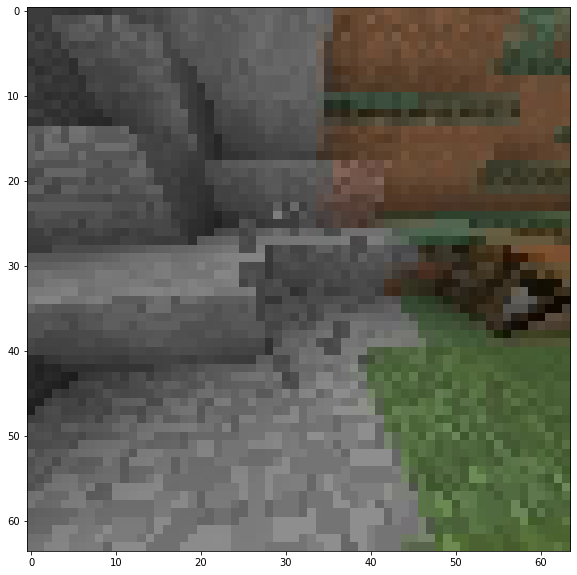

In [144]:
plt.imshow(train_features[0][1][3].permute(1, 2, 0))

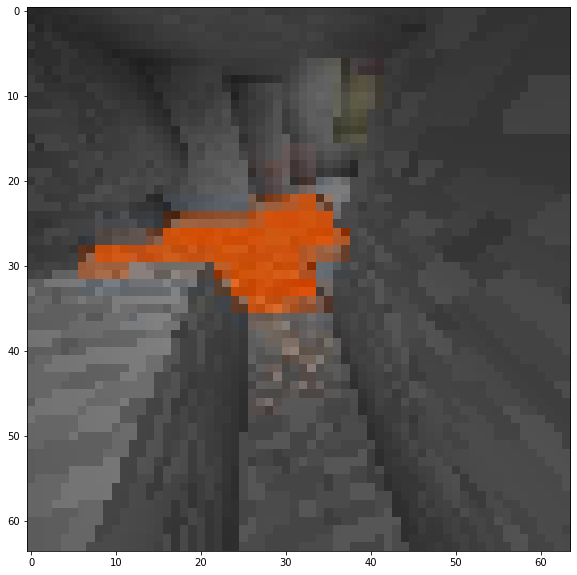

In [154]:
# 10000, 50000, 12000, 17000, 18000
recon_target = train_features[0][0][3].permute(1, 2, 0)
plt.imshow(recon_target)

In [155]:
image = torch.from_numpy(to_batch_shape(recon_target.numpy()).transpose(0, 3, 1, 2)).cuda()
image.shape

torch.Size([1, 3, 64, 64])

In [156]:
vision_model.eval()
outputs, latents = vision_model(image)
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

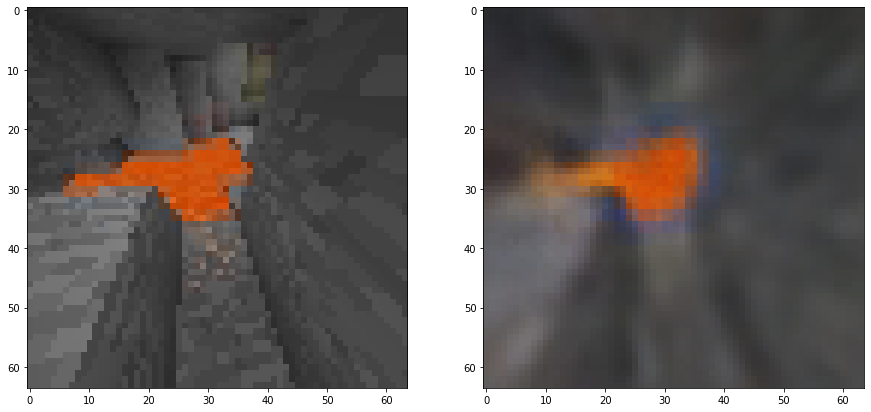

In [157]:
plt.subplot(1, 2, 1)
plt.imshow(recon_target)
plt.subplot(1, 2, 2)

plt.imshow(op[0])

In [149]:
op[0][0]

array([[0.24960913, 0.24539012, 0.23678155],
       [0.25351053, 0.24968044, 0.24194269],
       [0.25833488, 0.25616616, 0.2487176 ],
       [0.26793826, 0.26577255, 0.2581975 ],
       [0.28969893, 0.28415278, 0.283795  ],
       [0.30078563, 0.29561716, 0.29617837],
       [0.31561682, 0.3145585 , 0.31405067],
       [0.3252329 , 0.3241772 , 0.32416475],
       [0.3314343 , 0.32543066, 0.33033082],
       [0.33188272, 0.3256848 , 0.3281234 ],
       [0.3280371 , 0.32347113, 0.32472175],
       [0.32228667, 0.3174812 , 0.31874746],
       [0.3176781 , 0.31091183, 0.3089404 ],
       [0.30903354, 0.30239242, 0.3001148 ],
       [0.30569577, 0.3028387 , 0.30077332],
       [0.3017412 , 0.29875895, 0.29633632],
       [0.3265418 , 0.32644755, 0.32572097],
       [0.33362314, 0.33363476, 0.3331975 ],
       [0.3469591 , 0.3491673 , 0.34962353],
       [0.3478067 , 0.34966823, 0.35073853],
       [0.344802  , 0.34722748, 0.35300943],
       [0.34348318, 0.3460016 , 0.3516709 ],
       [0.

In [70]:
latents

tensor([[ 4.3896e-02, -2.1608e-03, -4.5932e-03,  2.1638e-02,  8.9031e-02,
          2.8313e-02, -4.8163e-02, -2.4450e-03, -1.6320e-02,  3.2331e-02,
          1.1464e-02,  4.0729e-02,  2.1753e-02,  1.6467e-02,  4.3867e-02,
          3.2611e-02, -5.4534e-02, -1.3786e-02, -2.4683e-03,  8.7111e-03,
          2.0631e-02,  8.3570e-02,  1.8864e-03, -3.4076e-02,  1.3493e-02,
         -4.7081e-03,  4.9126e-02,  8.8018e-02,  6.9812e-02, -2.2461e-02,
         -2.0747e-02, -4.7575e-02,  6.9988e-02,  1.1971e-02, -7.2818e-02,
         -3.7966e-02, -2.9416e-01,  3.3927e-02,  8.8970e-02, -1.4956e-01,
          1.6155e-02, -1.7791e-02,  1.8468e-02, -5.9973e-02,  3.8548e-02,
         -9.1864e-02, -2.5221e-02,  9.1401e-03,  1.2269e-01,  3.7177e-02,
         -1.5472e-01,  8.3359e-02, -5.9466e-03, -4.8158e-02, -1.6371e-02,
         -4.3600e-02, -8.2466e-02, -9.5641e-05, -2.8248e-02, -3.7517e-02,
          2.5488e-02, -5.5149e-02,  1.5191e-02, -4.0843e-02, -5.0967e-02,
         -3.2410e-02, -4.1375e-02, -2.

In [163]:
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
dataset = MineRlImageDataset("data/npy_obtain_diamond_all")
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [164]:
from delve import CheckLayerSat
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=vision_model, device=image.device)

added layer encoder-0
Skipping encoder-1
Skipping encoder-2
added layer encoder-3
Skipping encoder-4
Skipping encoder-5
added layer encoder-6
Skipping encoder-7
Skipping encoder-8
added layer encoder-9
Skipping encoder-10
Skipping encoder-11
added layer latent-mu
added layer unlatent
Skipping decoder-0
Skipping decoder-1
Skipping decoder-2
Skipping decoder-3
Skipping decoder-4
Skipping decoder-5
Skipping decoder-6
Skipping decoder-7
Skipping decoder-8
Skipping decoder-9
Skipping decoder-10
Skipping decoder-11


my_experiment_lsat_eval_epoch_0.png


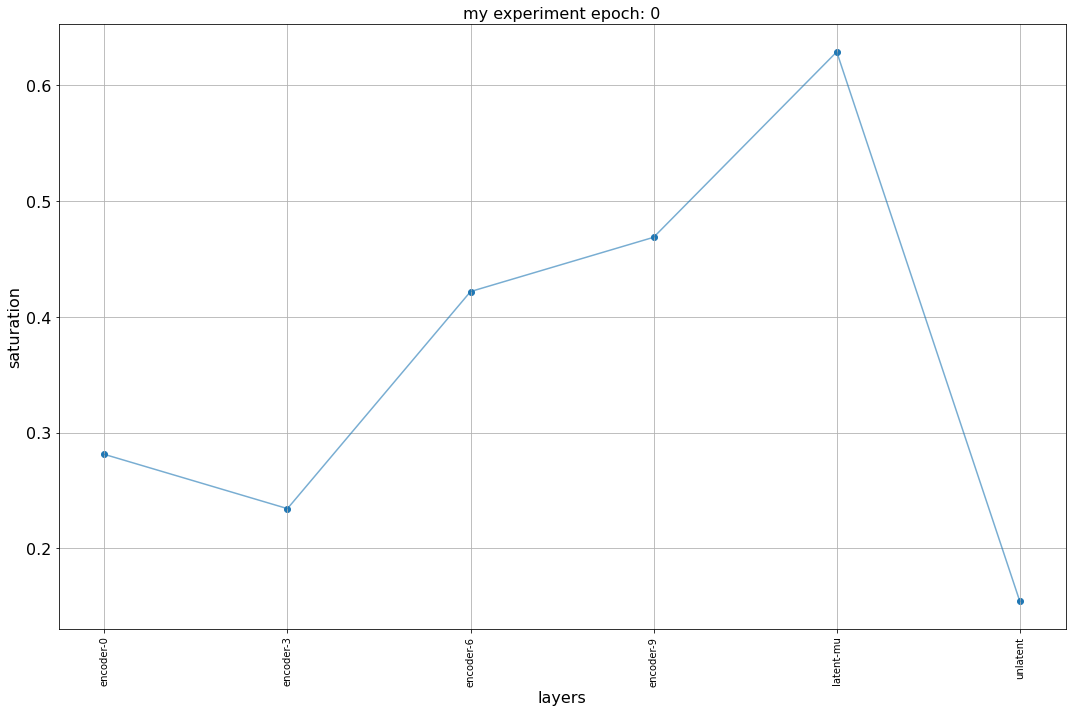

In [165]:
data = next(iter(train_dataloader))
image = data.transpose(-1, 1).cuda() / 255
outputs, latents = vision_model(image)
tracker.add_saturations()